In [258]:
# the two modules developed for this research
import smartQAOA as QAOA
import smartMQAOA as mQAOA
# File with plotting functions
import results_plotter as rp
# other relevant modules
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import expm
import networkx as nx
import bisect
import os
from scipy import stats

## Define Required Functions

#### Functions for converting between binary and integers:

In [259]:

def to_binary(x, bits):
    # Convert the integer to binary, fill with leading zeros, and reverse the order
    return np.array([int(i) for i in bin(x)[2:].zfill(bits)][::-1])
def to_int(x):
    # Reverse the order of the bits to convert back to normal binary representation
    return int(''.join([str(i) for i in x[::-1]]), 2)

#### Define the Hamming Distance:

In [260]:
def hamming_distance(partition1, partition2):
    # Calculate the Hamming distance
    distance = sum(v1 != v2 for v1, v2 in zip(partition1, partition2))
    return distance

#### Define Stanard QAOA:
Uses random parameter initilisation, and the QAOA package which I built. This function will be used to empericically demonstrate that the considered instances of QAOA suffer from the BP

In [261]:
def Standard_QAOA(G,n,p):
    Q,qc,gamma_parameters,time_parameters = QAOA.set_up_sim(n,p,G)
    
    # Reseed to ensure different outputs each time
    np.random.seed(None)
    gammas = np.random.uniform(0,2*np.pi,size=(p,))

    times = np.random.uniform(0,2*np.pi,size=(p,))
    result01=QAOA.expectation(Q,qc,G, gamma_parameters, time_parameters, gammas, times, p,optimize=False)

    return result01,Q

#### Define Function to Brute Force Solve MaxCut

In [262]:
def partition_to_list(partition, n):
    """Converts a partition (list of nodes) into a list of integers (0 or 1)"""
    partition_list = [0] * n  # Initialize a list of length n with all 0s
    for node in partition:
        partition_list[n - 1 - node] = 1  # Set the corresponding reversed index to 1
    return partition_list


# finds the maximum cut value and the optimal partitions for a given graph via brute force
# Requires a networkx graph as input, not an adjacency matrix
def max_cut_brute_force(G):
    n = G.number_of_nodes()  # Get the number of nodes in the graph
    nodes = list(G.nodes()) 
    max_cut = 0  # Initialize the maximum cut value
    optimal_partitions = []  

    # Iterate over all possible sizes of partitions
    for i in range(1, n//2 + 1):
        # Generate all combinations of the nodes for the current partition size

        for subset in combinations(nodes, i):
            subset_list = list(subset)  

            # Calculate the cut size: edges that have one endpoint in the subset and the other not in the subset are summed
            cut = sum(1 for edge in G.edges() if (edge[0] in subset_list) != (edge[1] in subset_list))
            
            # Update maximum cut value and partitions if a better cut is found
            if cut > max_cut:
                max_cut = cut
                optimal_partitions = [subset_list]  # Start a new list with the current partition
            elif cut == max_cut:
                optimal_partitions.append(subset_list)  # Append the current partition

    # Convert optimal partitions to list representation (0s and 1s for each node)
    partition_lists = [partition_to_list(partition, n) for partition in optimal_partitions]
    
    return max_cut, partition_lists

# Example usage
n = 4  # Number of nodes
adj_matrix = mQAOA.random_graph(n, G_type="3-regular", weighted=False)
G = nx.from_numpy_array(np.array(adj_matrix))  # Create a networkx graph from adjacency matrix

max_cut_value, partitions = max_cut_brute_force(G)
print(f"Maximum Cut Value: {max_cut_value}")
print(f"Number of Optimal Partitions: {len(partitions)}")
print("Example Optimal Partition(s) as Lists:")
for idx, partition in enumerate(partitions[:5], 1):  # Show up to 5 partitions
    print(f"Partition {idx}: {partition}")
# can verify the cut value of the optimal partitions
c = mQAOA.get_quality_vector(adj_matrix)
print(max(c)==c[to_int(partitions[0])])

Maximum Cut Value: 4
Number of Optimal Partitions: 6
Example Optimal Partition(s) as Lists:
Partition 1: [0, 0, 1, 1]
Partition 2: [0, 1, 0, 1]
Partition 3: [1, 0, 0, 1]
Partition 4: [0, 1, 1, 0]
Partition 5: [1, 0, 1, 0]
True


## Section 1: Graph Similarity (Edit Distance) and Solution Similarities (Hamming Distance)
This section computes the metrics described in Section 3.1 of the accompanying thesis. First they are calcualted for random graphs then for 3-regular graphs

In [263]:
# Claculate graph similarities for Random graphs
n=16
# Generate the Path graph
GP = mQAOA.random_graph(n, G_type="path", weighted=False)
edit_dist_ER30=[]
for i in range(200):
    # Generate random graphs over the a set range of seed values
    G = mQAOA.random_graph(n, G_type="random", weighted=False, seed=i,p=0.3)
    edit_dist_ER30.append(np.sum(G!=GP)/2) #the adjacency matrix double counts each edge   #/(np.sum(G+GP)))

print("The mean GED for the 200 ER30 graph instances is: ",np.mean(edit_dist_ER30),"with a standard deviation of: ",np.std(edit_dist_ER30))
#analytically expected value for edit distance
(36+15-2*15*0.3)

The mean GED for the 200 ER30 graph instances is:  42.145 with a standard deviation of:  5.037258679083297


42.0

In [264]:
# Calculate the edit distance for 3-regular graphs
n=16
# Generate the Path graph
GP = mQAOA.random_graph(n, G_type="path", weighted=False)
edit_dist_3R=[]
for i in range(200):
    # Generate random graphs over the a set range of seed values
    G = mQAOA.random_graph(n, G_type="3-regular", weighted=False, seed=i)
    edit_dist_3R.append(np.sum(G!=GP)/2) #the adjacency matrix double counts each edge  #/(np.sum(G+GP)))

print("The mean GED for the 200 3R graph instances is: ",np.mean(edit_dist_3R),"with a standard deviation of: ",np.std(edit_dist_3R))

The mean GED for the 200 3R graph instances is:  25.15 with a standard deviation of:  2.77803887661782


In [265]:
# calcualte the similarity between the Random Graph partitions and the Path graph partition

n=16
Path_p= [0,1]*(n//2) # Define MaxCut Partition for the Path graph

# Store the similarities for the random graph partitions
solution_similarities_mean_ER30 =[]
solution_similarities_min_ER30 =[]
for i in range(200):
    adj_matrix = mQAOA.random_graph(n, G_type="random", weighted=False, seed=i,p=0.3)
    c = mQAOA.get_quality_vector(adj_matrix)
    G = nx.from_numpy_array(np.array(adj_matrix))  
    max_cut_value, partitions = max_cut_brute_force(G) #find the optimal partitions
    local=[]
    # calculate the similarity between each of the optimal partitions and the Path graph partition
    for partition in partitions:
        hd=hamming_distance(partition,Path_p)
        local.append(min(n-hd,hd))
    solution_similarities_mean_ER30.append(np.mean(local))
    solution_similarities_min_ER30.append(min(local))
print(np.mean(solution_similarities_mean_ER30),np.std(solution_similarities_mean_ER30))
print(min(solution_similarities_mean_ER30),max(solution_similarities_mean_ER30))
print(np.mean(solution_similarities_min_ER30),np.std(solution_similarities_min_ER30))
print(min(solution_similarities_min_ER30),max(solution_similarities_min_ER30))

KeyboardInterrupt: 

In [ ]:
# calcualte the similarity between the 3-Regular Graph partitions and the Path graph

n=16
Path_p= [0,1]*(n//2) # Define MaxCut Partition for the Path graph

# Store the similarities for the random graph partitions
solution_similarities_mean_3R =[]
solution_similarities_min_3R =[]
for i in range(200):
    adj_matrix = mQAOA.random_graph(n, G_type="3-regular", weighted=False, seed=i)
    c = mQAOA.get_quality_vector(adj_matrix)
    G = nx.from_numpy_array(np.array(adj_matrix))  
    max_cut_value, partitions = max_cut_brute_force(G) #find the optimal partitions
    local=[]
    # calculate the similarity between each of the optimal partitions and the Path graph partition
    for partition in partitions:
        hd=hamming_distance(partition,Path_p)
        local.append(min(n-hd,hd))
    solution_similarities_mean_3R.append(np.mean(local))
    solution_similarities_min_3R.append(min(local))
print(np.mean(solution_similarities_mean_3R),np.std(solution_similarities_mean_3R))
print(min(solution_similarities_mean_3R),max(solution_similarities_mean_3R))
print(np.mean(solution_similarities_min_3R),np.std(solution_similarities_min_3R))
print(min(solution_similarities_min_3R),max(solution_similarities_min_3R))


6.062550323042971 1.2650322200917714
1.0 8.0
5.175 1.739073028943868
0 8


## Section 2: Demonstrate Barren Plateaus in QAOA

In [ ]:
""""""""""
# Trial 500 sets of random parameters, testing the variance in the costs in accordance with EQ XX in thesis
trials=500
variance = []
qubits=[4,6,8,10,12,14,16]
for n in qubits:
    p= n**2
    all_trials=[]
    bad_seeds =[]
    good_seeds =[]
    average_seeds=[]
    why_so_slow=[]
    costs=[]
    for t in range(trials):
        G=QAOA.random_graph(n,G_type="random",weighted=False,seed=1,p=0.3) # fixed graph
        if max(c) == 0:
            continue
        result0,c=Standard_QAOA(G,n,p)
        costs.append(result0)
    print("For n=",n)
    print("Variance in the costs: ",np.var(costs))
    variance.append(np.var(costs))
"""""""""

'"\n# Trial 500 sets of random parameters, testing the variance in the costs in accordance with EQ XX in thesis\ntrials=500\nvariance = []\nqubits=[4,6,8,10,12,14,16]\nfor n in qubits:\n    p= n**2\n    all_trials=[]\n    bad_seeds =[]\n    good_seeds =[]\n    average_seeds=[]\n    why_so_slow=[]\n    costs=[]\n    for t in range(trials):\n        G=QAOA.random_graph(n,G_type="random",weighted=False,seed=1,p=0.3) # fixed graph\n        if max(c) == 0:\n            continue\n        result0,c=Standard_QAOA(G,n,p)\n        costs.append(result0)\n    print("For n=",n)\n    print("Variance in the costs: ",np.var(costs))\n    variance.append(np.var(costs))\n'

In [ ]:
""""""""""
plt.figure(figsize=(10, 6))

plt.plot(qubits, variance, marker='o', label='Cost Variance')

plt.xlabel('Number of Qubits (n)')
plt.ylabel(r"$Var[C(\theta)]$")
plt.title('Variance in Cost Function Landscape vs Problem Size for ER pe=30 graphs')
plt.legend()
plt.grid(True)
plt.grid(True, which="both", ls="--")
plt.yscale("log")
plt.show()
"""""""""

'"\nplt.figure(figsize=(10, 6))\n\nplt.plot(qubits, variance, marker=\'o\', label=\'Cost Variance\')\n\nplt.xlabel(\'Number of Qubits (n)\')\nplt.ylabel(r"$Var[C(\theta)]$")\nplt.title(\'Variance in Cost Function Landscape vs Problem Size for ER pe=30 graphs\')\nplt.legend()\nplt.grid(True)\nplt.grid(True, which="both", ls="--")\nplt.yscale("log")\nplt.show()\n'

## Section 3: Plots for the Parameter Set {$\gamma^1,\beta$} found using pretraining with the Path Graph, compared with a typical Quantum Annealling inspired restricted parameter space intialisation scheme

NOTE: The parameters were found running on the supercomputer Setonix, and therefor the code which was run to find them is not included here. An examples of all codes run on Setonix can be found in the file FILE_NAME.ipynb

In [ ]:
# load the parameters for the 16 qubit path graph
initial_load = np.load('Graph_Parameters16_256.npz')
parameters = [initial_load[key] for key in initial_load]
Gamma1 = np.array(parameters[0])
Beta = np.array(parameters[1])
layer = [i for i in range(1,257)]


In [ ]:
# Demonstrate the convergence
GP=QAOA.random_graph(16,G_type="path",weighted=False,seed=1,p=0.3)
Q,qc,gamma_params,time_params=QAOA.set_up_sim(16,256,GP)

In [ ]:
result= QAOA.expectation(Q,qc,GP,gamma_params,time_params,Gamma1,Beta,256,optimize=False,return_max_prob=True)
print("The approximation ratio is: ",result[0]/15, "with ", 100*result[1], "% of the probability on the optimal solution")

The approximation ratio is:  0.9999999859159224 with  99.99998797735597 % of the probability on the optimal solution


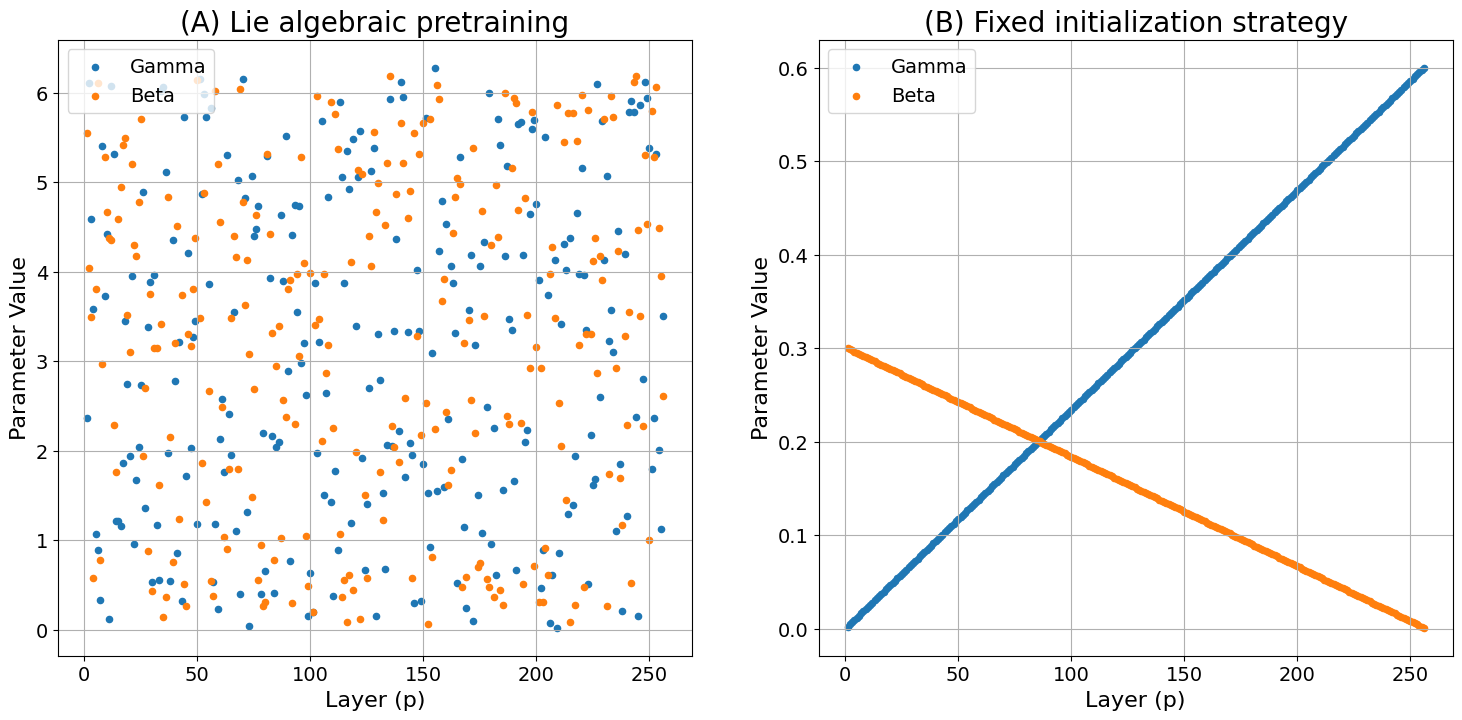

In [ ]:

# Given constants
delta_beta = 0.3
delta_gamma = 0.6
p = 256

# Generate standard fixed initialization strategy parameters
beta = [(1 - i/p) * delta_beta for i in range(p)]
gamma = [(i + 1)/p * delta_gamma for i in range(p)]



##### Code to plot
TITLE_SIZE = 20
LABEL_SIZE = 16
TICK_SIZE = 14
LEGEND_SIZE = 14

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))  

ax1.scatter(layer, Gamma1, label='Gamma', s=20)  
ax1.scatter(layer, Beta, label='Beta', s=20)
ax1.set_xlabel('Layer (p)', fontsize=LABEL_SIZE)
ax1.set_ylabel('Parameter Value', fontsize=LABEL_SIZE)
ax1.set_title('(A) Lie algebraic pretraining', fontsize=TITLE_SIZE)
ax1.grid(True)
ax1.legend(fontsize=LEGEND_SIZE)
ax1.tick_params(axis='both', which='major', labelsize=TICK_SIZE)


ax2.scatter(layer, gamma, label='Gamma', s=20)
ax2.scatter(layer, beta, label='Beta', s=20)
ax2.set_xlabel('Layer (p)', fontsize=LABEL_SIZE)
ax2.set_ylabel('Parameter Value', fontsize=LABEL_SIZE)
ax2.set_title('(B) Fixed initialization strategy', fontsize=TITLE_SIZE)
ax2.grid(True)
ax2.legend(fontsize=LEGEND_SIZE)
ax2.tick_params(axis='both', which='major', labelsize=TICK_SIZE)


# Display the plots
plt.show()

## Section 4: Plots Generated by 100 trials of QAOA on Unweighted ER graphs with Edge probability of 30%

This section presents the data generated by 100 trials of ER graphs using Setonix. Refer to FILENAME for example code.

In [ ]:
#Pretrained_ER_results,Pretrained_3R_results = rp.plot_and_analyze_results("Pretrained QAOA on Erdros-Renyi Graph", NXedit_dist_ER30, solution_similarities_min_ER30, solution_similarities_mean_ER30, "Pretrained QAOA on 3-Regular Graph", NXedit_dist_3R, solution_similarities_min_3R, solution_similarities_mean_3R)
Random_ER_results = rp.process_folder2("FINAL_ER30_RANDOM", edit_dist_ER30, solution_similarities_min_ER30, solution_similarities_mean_ER30)
Pretrained_ER_results = rp.process_folder2("FINAL_ER30_PRETRAINED", edit_dist_ER30, solution_similarities_min_ER30, solution_similarities_mean_ER30)

Folder 'FINAL_ER30_RANDOM':
  Total files processed: 200
  Instances better than 0.878: 0
  Fraction better than 0.878: 0.0000
  Instances in local minima: 0
  Instances stuck on BP: 200
  Instances which converged: 0

Folder 'FINAL_ER30_PRETRAINED':
  Total files processed: 200
  Instances better than 0.878: 99
  Fraction better than 0.878: 0.4950
  Instances in local minima: 32
  Instances stuck on BP: 47
  Instances which converged: 6



In [ ]:
Random_3R_results = rp.process_folder2("FINAL_3R_RANDOM", edit_dist_3R, solution_similarities_min_3R, solution_similarities_mean_3R)
Pretrained_3R_results = rp.process_folder2("FINAL_3R_PRETRAINED", edit_dist_3R, solution_similarities_min_3R, solution_similarities_mean_3R)

Folder 'FINAL_3R_RANDOM':
  Total files processed: 200
  Instances better than 0.878: 0
  Fraction better than 0.878: 0.0000
  Instances in local minima: 0
  Instances stuck on BP: 200
  Instances which converged: 0

Folder 'FINAL_3R_PRETRAINED':
  Total files processed: 200
  Instances better than 0.878: 134
  Fraction better than 0.878: 0.6700
  Instances in local minima: 60
  Instances stuck on BP: 7
  Instances which converged: 15



### Confidence interval calculation for the true proportion which surpasses GW

In [ ]:
confidence = 0.95  # 95% confidence interval
total_instances =200

# Proportion of instances surpassing GW threshold
p_hat = 0.495

# Z-score for the confidence level 
z_score = stats.norm.ppf(1 - (1 - confidence) / 2)

# Standard error for the proportion
se = np.sqrt((p_hat * (1 - p_hat)) / total_instances)

# Margin of error
margin_of_error = z_score * se

# Confidence interval
lower_bound = p_hat - margin_of_error
upper_bound = p_hat + margin_of_error

# Output results
print(f"Proportion of instances surpassing GW: {p_hat:.2%}")
print(f"95% Confidence Interval: ({lower_bound*100:.2f}%, {upper_bound*100:.2f}%)")

Proportion of instances surpassing GW: 49.50%
95% Confidence Interval: (42.57%, 56.43%)


In [ ]:
confidence = 0.95  # 95% confidence interval
total_instances =200

# Proportion of instances surpassing GW threshold
p_hat = 0.67

# Z-score for the confidence level 
z_score = stats.norm.ppf(1 - (1 - confidence) / 2)

# Standard error for the proportion
se = np.sqrt((p_hat * (1 - p_hat)) / total_instances)

# Margin of error
margin_of_error = z_score * se

# Confidence interval
lower_bound = p_hat - margin_of_error
upper_bound = p_hat + margin_of_error

# Output results
print(f"Proportion of instances surpassing GW: {p_hat:.2%}")
print(f"95% Confidence Interval: ({lower_bound*100:.2f}%, {upper_bound*100:.2f}%)")

Proportion of instances surpassing GW: 67.00%
95% Confidence Interval: (60.48%, 73.52%)


### Plot all of the trials

The final mean approximation ratio for Erdros-Renyi Graph using Pretrained QAOA is 88.79%

The final mean approximation ratio for Erdros-Renyi Graph using Randomly initialised QAOA is 60.38%

The final mean approximation ratio for 3-Regular Graph using Pretrained QAOA is 83.97%

The final mean approximation ratio for 3-Regular Graph using Randomly initialised QAOA is 66.63%



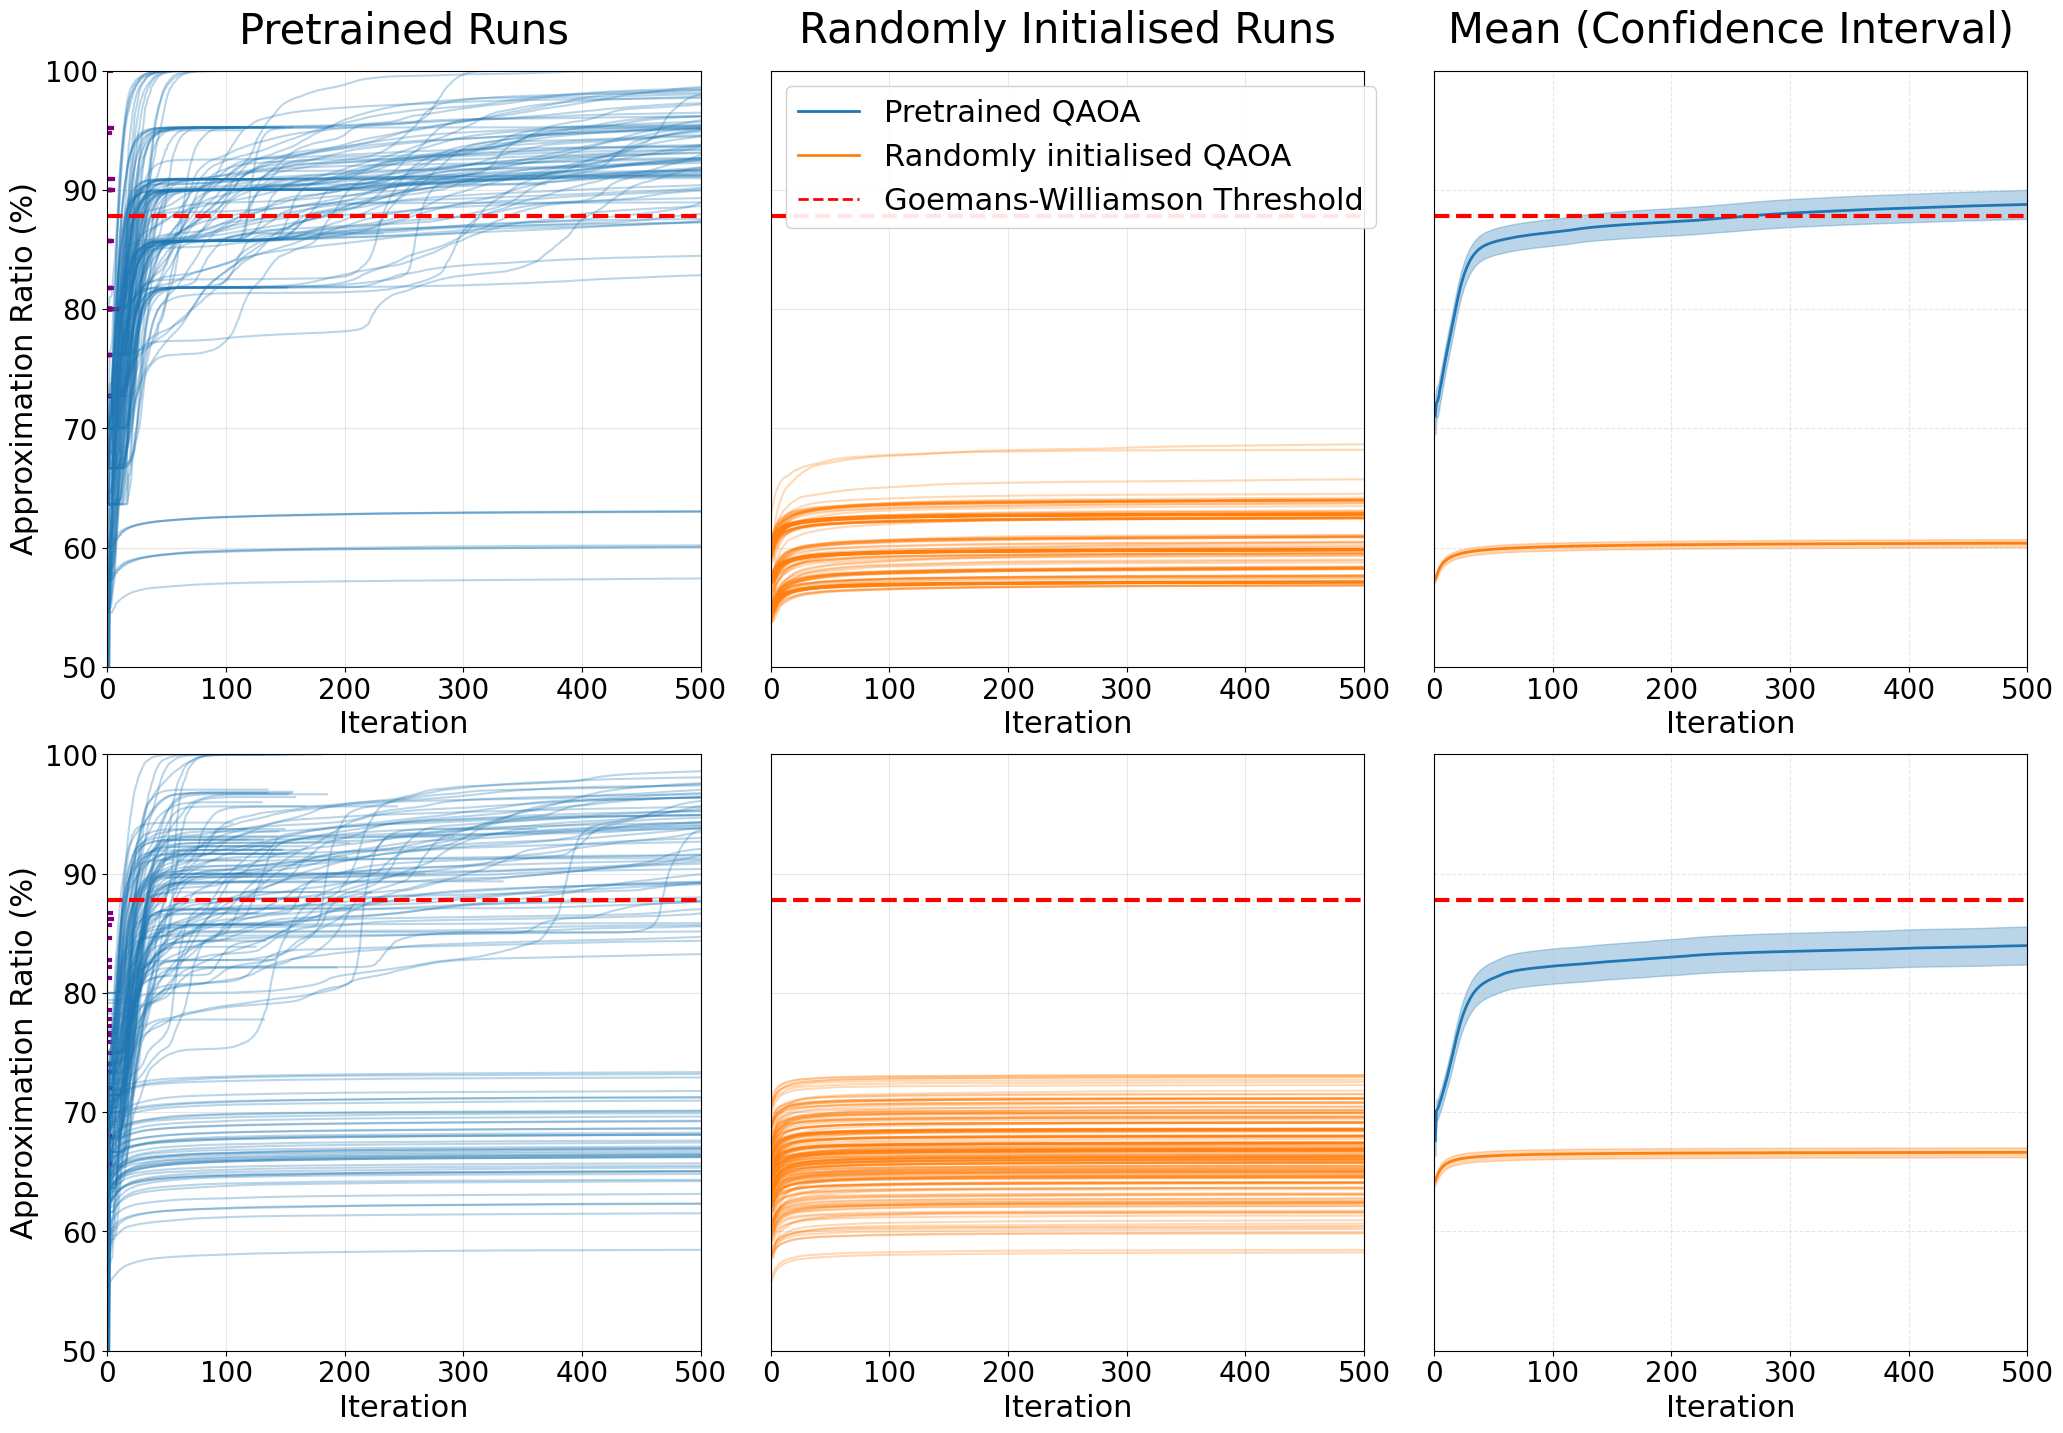

In [ ]:
labels = ["Pretrained QAOA","Randomly initialised QAOA"]
all_runs = [[Pretrained_3R_results['all_runs'],Random_3R_results['all_runs']],[Pretrained_ER_results['all_runs'],Random_ER_results['all_runs']]]
names = [ "3-Regular Graph","Erdros-Renyi Graph"]
rp.plot_combined_horizontal(Random_ER_results, Pretrained_ER_results, Random_3R_results, Pretrained_3R_results, all_runs, names, labels)

In [ ]:
# get the indices which give the local minima instances and the instances which dont improve
# upon the randomly initialised QAOA, but are not stuck in local minima
indices_LM_3R = [i for i, x in enumerate(Pretrained_3R_results['all_runs']) if len(x)<20]
indices_LM_ER = [i for i, x in enumerate(Pretrained_ER_results['all_runs']) if len(x)<20]
indices_BP_3R = [i for i, x in enumerate(Pretrained_3R_results['all_runs']) if len(x)>20 and x[-1]<0.75] 
indices_BP_ER = [i for i, x in enumerate(Pretrained_ER_results['all_runs']) if len(x)>20 and x[-1]<0.75]

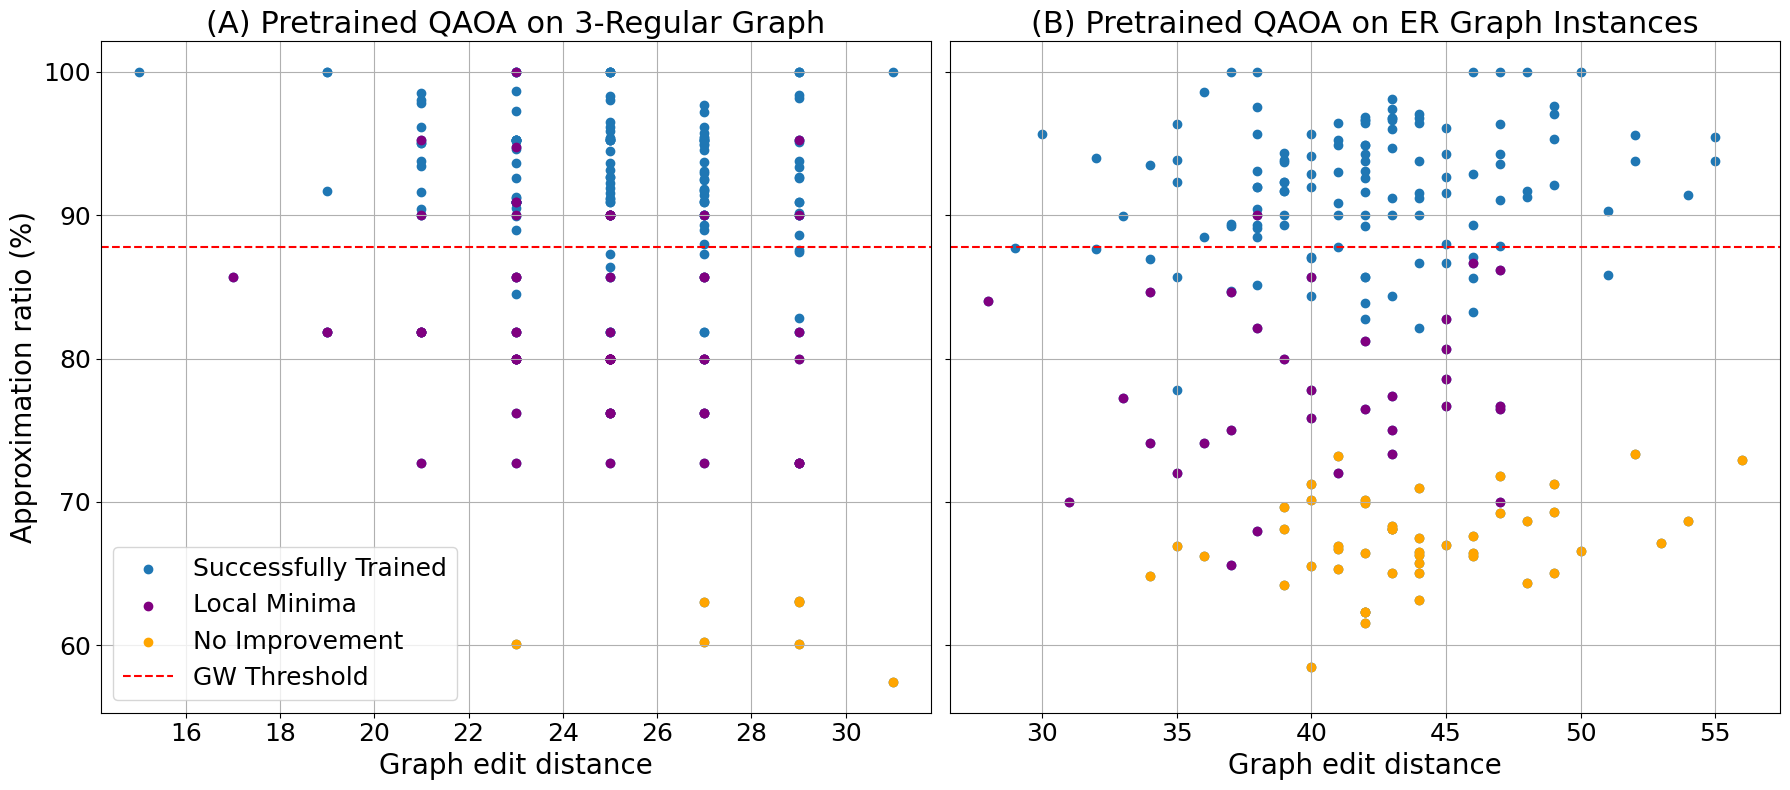

In [293]:
# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(18, 8),sharey=True)  # Increased height for better readability

# Define font sizes
title_fontsize = 22
label_fontsize = 20
tick_fontsize = 18

# First scatter plot on the left subplot
axs[0].scatter(
    np.array(Pretrained_3R_results["edit_dists"])[:, 0],
    100 * np.array(Pretrained_3R_results["edit_dists"])[:, 1],
    label='Successfully Trained'
)
axs[0].scatter(
    np.array(Pretrained_3R_results["edit_dists"])[indices_LM_3R, 0],
    100 *np.array(Pretrained_3R_results["edit_dists"])[indices_LM_3R, 1],
    label='Local Minima',color='purple'
)
axs[0].scatter(
    np.array(Pretrained_3R_results["edit_dists"])[indices_BP_3R, 0],
    100 *np.array(Pretrained_3R_results["edit_dists"])[indices_BP_3R, 1],
    label='No Improvement',color='orange'
)
axs[0].set_title(
    '(A) Pretrained QAOA on 3-Regular Graph',
    fontsize=title_fontsize
)
axs[0].set_xlabel('Graph edit distance', fontsize=label_fontsize)
axs[0].set_ylabel('Approximation ratio (%)', fontsize=label_fontsize)
axs[0].tick_params(axis='both', which='major', labelsize=tick_fontsize)
axs[0].grid(True)
axs[0].axhline(y=87.8, color='red', linestyle='--',label="GW Threshold")  # Add horizontal line at 87.8
axs[0].legend(loc='lower left', fontsize=18)

# Second scatter plot on the right subplot
axs[1].scatter(
    np.array(Pretrained_ER_results["edit_dists"])[:, 0],
    100 * np.array(Pretrained_ER_results["edit_dists"])[:, 1],
    label='Edit Distance'
)
axs[1].scatter(
    np.array(Pretrained_ER_results["edit_dists"])[indices_LM_ER, 0],
    100 *np.array(Pretrained_ER_results["edit_dists"])[indices_LM_ER, 1],
    label='Edit Distance2',color='purple'
)
axs[1].scatter(
    np.array(Pretrained_ER_results["edit_dists"])[indices_BP_ER, 0],
    100 *np.array(Pretrained_ER_results["edit_dists"])[indices_BP_ER, 1],
    label='Edit Distance3',color='orange'
)
axs[1].set_title(
    '(B) Pretrained QAOA on ER Graph Instances',
    fontsize=title_fontsize
)
axs[1].set_xlabel('Graph edit distance', fontsize=label_fontsize)
# Disable y-axis ticks and labels
axs[1].tick_params(axis='both', which='major', labelsize=tick_fontsize)
axs[1].grid(True)
axs[1].axhline(y=87.8, color='red', linestyle='--')  # Add horizontal line at 87.8

# Adjust layout to prevent overlap
plt.tight_layout()


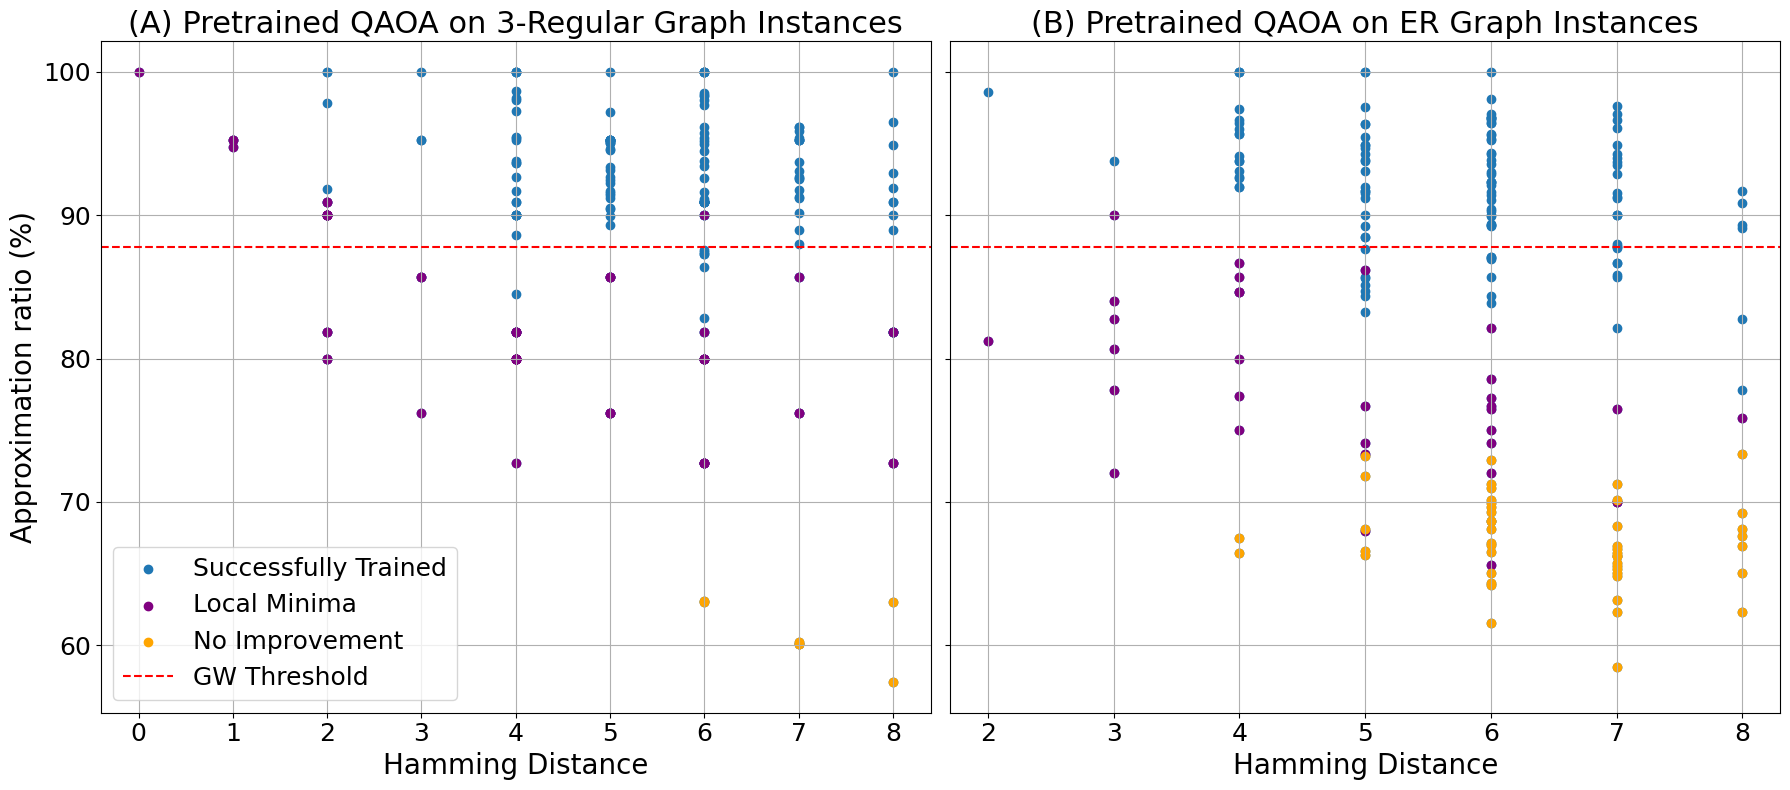

In [292]:
fig, axs = plt.subplots(1, 2, figsize=(18, 8),sharey=True)  # Increased height for better readability

# Define font sizes
title_fontsize = 22
label_fontsize = 20
tick_fontsize = 18

# First scatter plot on the left subplot
axs[0].scatter(
    np.array(Pretrained_3R_results['hamming_dists_min'])[:, 0],
    100 * np.array(Pretrained_3R_results['hamming_dists_min'])[:, 1],
    label="Successfully Trained"
)
axs[0].scatter(
    np.array(Pretrained_3R_results['hamming_dists_min'])[indices_LM_3R, 0],
    100 * np.array(Pretrained_3R_results['hamming_dists_min'])[indices_LM_3R, 1],
    label="Local Minima",color='purple'
)
axs[0].scatter(
    np.array(Pretrained_3R_results['hamming_dists_min'])[indices_BP_3R, 0],
    100 * np.array(Pretrained_3R_results['hamming_dists_min'])[indices_BP_3R, 1],
    label="No Improvement",color='orange'
)
axs[0].set_title(
    '(A) Pretrained QAOA on 3-Regular Graph Instances',
    fontsize=title_fontsize
)
axs[0].set_xlabel('Hamming Distance', fontsize=label_fontsize)
axs[0].set_ylabel('Approximation ratio (%)', fontsize=label_fontsize)
axs[0].tick_params(axis='both', which='major', labelsize=tick_fontsize)
axs[0].grid(True)
axs[0].axhline(y=87.8, color='red', linestyle='--',label="GW Threshold")  # Add horizontal line at 87.8
axs[0].legend(loc='lower left', fontsize=18)

# Second scatter plot on the right subplot
axs[1].scatter(
    np.array(Pretrained_ER_results['hamming_dists_min'])[:, 0],
    100 * np.array(Pretrained_ER_results['hamming_dists_min'])[:, 1],
    label="Successfully Trained"
)
axs[1].scatter(
    np.array(Pretrained_ER_results['hamming_dists_min'])[indices_LM_ER, 0],
    100 * np.array(Pretrained_ER_results['hamming_dists_min'])[indices_LM_ER, 1],
    label="Local Minima",color='purple'
)
axs[1].scatter(
    np.array(Pretrained_ER_results['hamming_dists_min'])[indices_BP_ER, 0],
    100 * np.array(Pretrained_ER_results['hamming_dists_min'])[indices_BP_ER, 1],
    label="Barren Plateau",color='orange'
)
axs[1].set_title(
    '(B) Pretrained QAOA on ER Graph Instances',
    fontsize=title_fontsize
)
axs[1].set_xlabel('Hamming Distance', fontsize=label_fontsize)
# Disable y-axis ticks and labels
axs[1].tick_params(axis='both', which='major', labelsize=tick_fontsize)
axs[1].grid(True)
axs[1].axhline(y=87.8, color='red', linestyle='--')  # Add horizontal line at 87.8

# Adjust layout to prevent overlap
plt.tight_layout()



## Section 5: Cost Distribution and Percentile of Path Graph Solution

In [ ]:
# gets the partition which solves MaxCut for the Path Graph
def PathPartion(n):
    string= [0,1]*(n//2)
    if n%2 !=0:
        string.append(0)
    return string

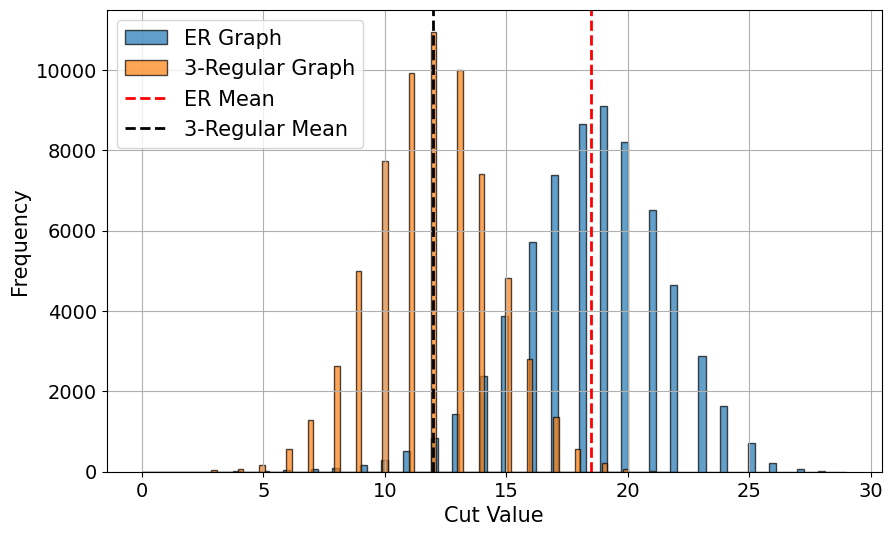

In [ ]:
# Set label and tick font sizes
label_fontsize = 15
tick_fontsize = 14

# Generate an Erdős-Rényi (ER) random graph
G = mQAOA.random_graph(16, G_type="random", weighted=False, p=0.3, seed=1)
# Get the quality vector
c_er = mQAOA.get_quality_vector(G)
# Calculate the mean of the quality vector
mean_c_er = np.mean(c_er)

# Generate a 3-regular graph
G = mQAOA.random_graph(16, G_type="3-regular", weighted=False, seed=42)
# Get the quality vector
c_reg = mQAOA.get_quality_vector(G)
# Calculate the mean of the quality vector
mean_c_reg = np.mean(c_reg)

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(c_er, bins=100, edgecolor='black', alpha=0.7, label='ER Graph')
plt.hist(c_reg, bins=100, edgecolor='black', alpha=0.7, label='3-Regular Graph')

# Add vertical lines to highlight the means
plt.axvline(mean_c_er, color='red', linestyle='dashed', linewidth=2, label='ER Mean')
plt.axvline(mean_c_reg, color='black', linestyle='dashed', linewidth=2, label='3-Regular Mean')

# Adding labels and title
plt.xlabel('Cut Value', fontsize=label_fontsize)
plt.ylabel('Frequency', fontsize=label_fontsize)
plt.grid(True)

# Adjust tick font sizes
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)

# Add a legend to distinguish the mean and percentile lines
plt.legend(fontsize=label_fontsize)

# Display the histogram
plt.show()


### Erdros-Renyi (Edge probability 30%) Percentile

In [ ]:
# Define the number of qubits and trials for all runs
qubits =[6,8,10,12,14,16]
trials= 200

In [ ]:
#Empirical expected initial percentile for random QAOA
n=16
p=n**2
all_trials = []
for t in range(trials):
    G=mQAOA.random_graph(n,G_type="random",weighted=False,seed=t)
    result0,c=Standard_QAOA(G,n,p)
    if max(c) == 0:
        continue
    percentile=stats.percentileofscore(c, result0,kind="rank")
    all_trials.append(percentile)
print("For n=",n)
print("Average percentile: ",np.mean(all_trials), "std: ", np.std(all_trials))

KeyboardInterrupt: 

In [ ]:
# Calcualte mean cost (ie the vlaue at which the BP occurs) for the ER Graphs
Rmedian_ER_percentiles = []
Raverage_ER_percentiles = []
Rfraction_ER_above_55th = []
R_ER_std = []
means=[]
Rall_trials16_ER =[]
for n in qubits:
    p=n**2
    all_trials=[]
    bad_seeds =[]
    good_seeds =[]
    average_seeds=[]
    why_so_slow=[]
    costs=[]
    for t in range(trials):
        G=mQAOA.random_graph(n,G_type="random",weighted=False,seed=t,p=0.3)
        c=mQAOA.get_quality_vector(G)
        if max(c) == 0:
            continue
        expected_c = sum(c)/(2**n) # from analytical solution
        means.append(expected_c/max(c))
        percentile=stats.percentileofscore(c, expected_c,kind="rank") 
        all_trials.append(percentile)
    if n==16:
        Rall_trials16_ER=all_trials
    print("For n=",n)
    print("Average percentile: ",np.mean(all_trials)," Median percentile: ", np.median(all_trials), "std: ", np.std(all_trials), "max: ", max(all_trials), "min: ", min(all_trials))
    Rmedian_ER_percentiles.append(np.median(all_trials))
    Raverage_ER_percentiles.append(np.mean(all_trials))
    R_ER_std.append(np.std(all_trials))
    print("Average expected approximation ratio (%): ",100*np.mean(means), "std: ", 100*np.std(means), "max: ",100*max(means), "min: ", 100*min(means))
    

For n= 6
Average percentile:  48.32364949748744  Median percentile:  50.0 std:  4.201971256778024 max:  56.25 min:  25.0
Average expected approximation ratio (%):  54.59798994974875 std:  6.403912171995685 max:  75.0 min:  50.0
For n= 8
Average percentile:  47.953125  Median percentile:  48.2421875 std:  2.8423814100289433 max:  68.75 min:  35.15625
Average expected approximation ratio (%):  55.915785690221774 std:  6.125292424638751 max:  75.0 min:  50.0
For n= 10
Average percentile:  48.045654296875  Median percentile:  48.046875 std:  1.6094140909132493 max:  54.6875 min:  41.455078125
Average expected approximation ratio (%):  57.06205707666475 std:  5.855460976032106 max:  75.0 min:  50.0
For n= 12
Average percentile:  47.93670654296875  Median percentile:  48.0224609375 std:  1.1232693907843576 max:  50.439453125 min:  44.82421875
Average expected approximation ratio (%):  58.0642686531732 std:  5.652849415282249 max:  75.0 min:  50.0
For n= 14
Average percentile:  47.94673156738

In [ ]:
def split_above_random(values):
    # Sort the list
    sorted_values = sorted(values)
    
    # Determine the indices for the 30% split
    n = len(sorted_values)

    left_index = bisect.bisect_right(sorted_values, 49.43)

    
    return ((n-left_index)/n)*100

In [ ]:
# Calcualte the percentile at which the path graph occurs for the ER Graphs
Pmedian_ER_percentiles = []
Paverage_ER_percentiles = []
Pfraction_ER_above_55th = []
P_ER_std = []
Pfraction_above_47th_ER = []
Pall_trials16_ER=[]
compare_to_random=[]
for n in qubits:
    p=n**2
    all_trials=[]
    for t in range(trials):
        G=mQAOA.random_graph(n,G_type="random",weighted=False,seed=t,p=0.3)
        c=mQAOA.get_quality_vector(G)
        if max(c) == 0:
            continue
        p=stats.percentileofscore(c, c[to_int(PathPartion(n))],kind="rank")
        all_trials.append(p)
    if n==16:
        Pall_trials16_ER=all_trials
    print("For n=",n)
    print("Average percentile: ",np.mean(all_trials)," Median percentile: ", np.median(all_trials), "std: ", np.std(all_trials),"max: ", max(all_trials), "min: ", min(all_trials))
    Pmedian_ER_percentiles.append(np.median(all_trials))
    Paverage_ER_percentiles.append(np.mean(all_trials))
    P_ER_std.append(np.std(all_trials))
    print("Percentage of trials above Random Start: ",split_above_random(all_trials))
    Pfraction_above_47th_ER.append(split_above_random(all_trials))

For n= 6
Average percentile:  60.69016959798995  Median percentile:  63.28125 std:  23.407582407403044 max:  97.65625 min:  3.90625
Percentage of trials above Random Start:  72.36180904522614
For n= 8
Average percentile:  59.6328125  Median percentile:  63.8671875 std:  25.479455188813397 max:  99.4140625 min:  4.8828125
Percentage of trials above Random Start:  63.0
For n= 10
Average percentile:  61.40283203125  Median percentile:  66.40625 std:  24.815109303103227 max:  99.951171875 min:  4.541015625
Percentage of trials above Random Start:  67.5
For n= 12
Average percentile:  62.9376220703125  Median percentile:  66.12548828125 std:  26.711701856378372 max:  99.91455078125 min:  3.18603515625
Percentage of trials above Random Start:  67.0
For n= 14
Average percentile:  63.835418701171875  Median percentile:  63.9923095703125 std:  24.386295182005675 max:  99.5941162109375 min:  4.3731689453125
Percentage of trials above Random Start:  70.5
For n= 16
Average percentile:  60.687713623

### 3-Regular Percentiles:
This code demonstrates the percentile in which the random QAOA initialises in for 16 qubits, as well as the percentile which the pretrained model initialises in. The pretrained initital state is known to be fixed as the solution to the path graph, the alternating 01 state, and therfor does not need to be computed. This allows for the percentile to scalling to be effeicently found at varying qubit levels. For the random QAOA multiple empirical trials are run at only 16 qubits as it is computationally expensive (requires running the full circuit). These are seen to correspond to the analytical values, which is therfor used for the rest of the trials

In [ ]:
# Percentile of the mean value (ie the value at which the BP occurs) for the 3-Regular Graphs
Rmedian_3R_percentiles = []
Raverage_3R_percentiles = []
Rfraction_3R_above_55th = []
R_3R_std = []
Rall_trials16_3R = []
for n in qubits:
    p=n**2
    all_trials=[]
    bad_seeds =[]
    good_seeds =[]
    average_seeds=[]
    why_so_slow=[]
    costs=[]
    for t in range(trials):
        G=mQAOA.random_graph(n,G_type="3-regular",weighted=False,seed=t)
        c=mQAOA.get_quality_vector(G)
        if max(c) == 0:
            continue
        percentile=stats.percentileofscore(c, sum(c)/(2**n),kind="rank")
        percentile
        all_trials.append(percentile)
    if n==16:
        Rall_trials16_3R = all_trials
    print("For n=",n)
    print("Average percentile: ",np.mean(all_trials)," Median percentile: ", np.median(all_trials), "std: ", np.std(all_trials), "max: ", max(all_trials), "min: ", min(all_trials))
    Rmedian_3R_percentiles.append(np.median(all_trials))
    Raverage_3R_percentiles.append(np.mean(all_trials))
    R_3R_std.append(np.std(all_trials))

For n= 6
Average percentile:  52.6875  Median percentile:  53.125 std:  1.084334473306092 max:  53.125 min:  50.0
For n= 8
Average percentile:  47.244140625  Median percentile:  47.0703125 std:  2.5005179822275543 max:  50.9765625 min:  36.1328125
For n= 10
Average percentile:  49.921875  Median percentile:  49.609375 std:  1.1548238671167566 max:  52.734375 min:  47.65625
For n= 12
Average percentile:  48.99462890625  Median percentile:  49.03564453125 std:  0.7639641946221517 max:  50.54931640625 min:  46.83837890625
For n= 14
Average percentile:  49.50274658203125  Median percentile:  49.59716796875 std:  0.6500430137588002 max:  50.87890625 min:  47.76611328125
For n= 16
Average percentile:  49.430335998535156  Median percentile:  49.391937255859375 std:  0.4620270061095434 max:  50.316619873046875 min:  48.117828369140625


In [ ]:
def split_above_random(values):
    # Sort the list
    sorted_values = sorted(values)
    
    # Determine the indices for the 30% split
    n = len(sorted_values)

    left_index = bisect.bisect_right(sorted_values, 49.43)

    
    return ((n-left_index)/n)*100

In [ ]:
# percentile of the pathe graph solution for the 3-Regular Graphs
Pmedian_3R_percentiles = []
Paverage_3R_percentiles = []
Pfraction_3R_above_55th = []
P_3R_std = []
Pfraction_above_47th = []
Pall_trials16_3R =[]
for n in qubits:
    all_trials=[]
    bad_seeds =[]
    good_seeds =[]
    average_seeds=[]
    costs=[]
    for t in range(trials):
        G=mQAOA.random_graph(n,G_type="3-regular",weighted=False,seed=t)
        c=mQAOA.get_quality_vector(G)
        if max(c) == 0:
            continue
        p=stats.percentileofscore(c, c[to_int(PathPartion(n))],kind="rank")
        all_trials.append(p)
    if n==16:
        Pall_trials16_3R=all_trials
    print("For n=",n)
    print("Average percentile: ",np.mean(all_trials)," Median percentile: ", np.median(all_trials), "std: ", np.std(all_trials),"max: ", max(all_trials), "min: ", min(all_trials))
    Pmedian_3R_percentiles.append(np.median(all_trials))
    Paverage_3R_percentiles.append(np.mean(all_trials))
    P_3R_std.append(np.std(all_trials))
    print("Percentage of trials above Random Start: ",split_above_random(all_trials))
    Pfraction_above_47th.append(split_above_random(all_trials))

For n= 6
Average percentile:  81.296875  Median percentile:  96.09375 std:  16.364463153335493 max:  99.21875 min:  63.28125
Percentage of trials above Random Start:  100.0
For n= 8
Average percentile:  72.984375  Median percentile:  87.890625 std:  24.150276185661934 max:  99.8046875 min:  1.3671875
Percentage of trials above Random Start:  70.5
For n= 10
Average percentile:  76.796875  Median percentile:  77.392578125 std:  21.501659861520857 max:  99.951171875 min:  10.498046875
Percentage of trials above Random Start:  80.0
For n= 12
Average percentile:  79.1510009765625  Median percentile:  91.80908203125 std:  20.600109533356108 max:  99.96337890625 min:  8.38623046875
Percentage of trials above Random Start:  89.5
For n= 14
Average percentile:  78.20767211914062  Median percentile:  85.8062744140625 std:  20.170491258066207 max:  99.8809814453125 min:  25.1129150390625
Percentage of trials above Random Start:  93.5
For n= 16
Average percentile:  80.99925994873047  Median percent

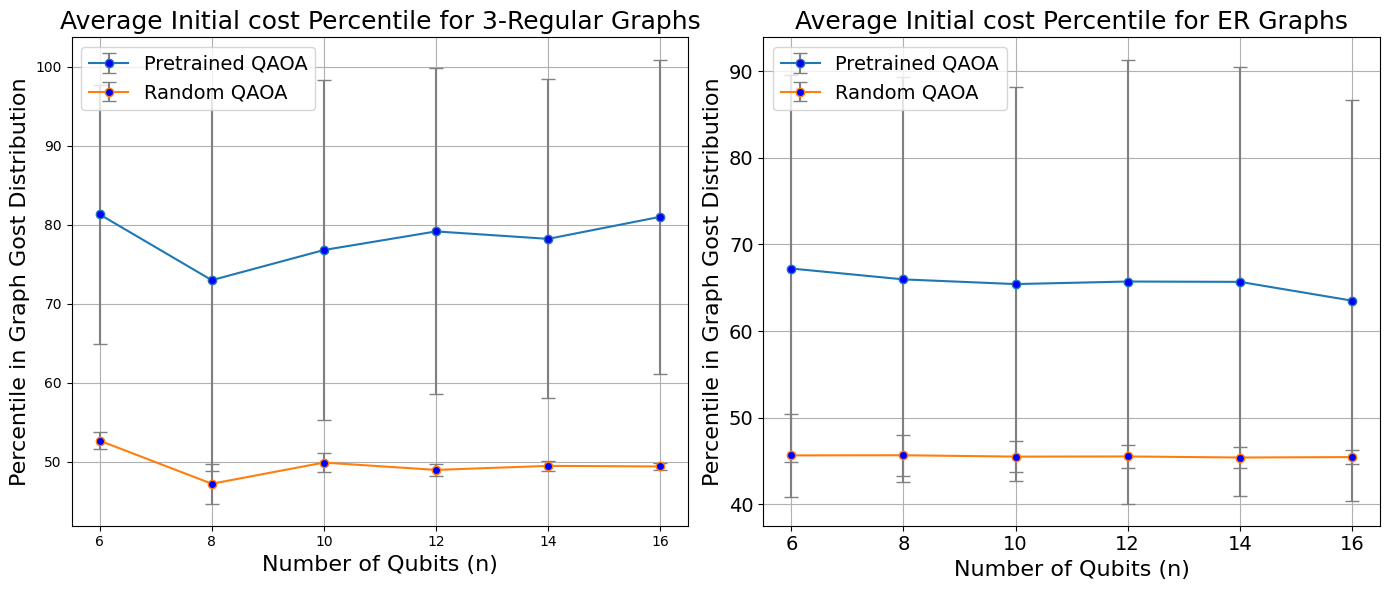

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# First plot: 3-Regular Graphs
ax1.errorbar(
    qubits, 
    Paverage_3R_percentiles, 
    yerr = P_3R_std, 
    fmt = 'o',  
    capsize= 5,  
    label ='Pretrained QAOA',
    ecolor='gray',  
    linestyle='-',   
    markerfacecolor='blue'
)

ax1.errorbar(
    qubits, 
    Raverage_3R_percentiles, 
    yerr=R_3R_std, 
    fmt='o',  
    capsize=5,  
    label='Random QAOA',
    ecolor='gray',  
    linestyle='-',   
    markerfacecolor='blue'
)

ax1.set_xlabel('Number of Qubits (n)',fontsize=16)
ax1.set_ylabel('Percentile in Graph Gost Distribution',fontsize=16)
ax1.set_title('Average Initial cost Percentile for 3-Regular Graphs',fontsize=18)
ax1.legend(fontsize=14,loc='upper left')
ax1.grid(True)
ax2.tick_params(axis='both', which='major', labelsize=14)

# Second plot: Erdros-Renyi Graphs
ax2.errorbar(
    qubits, 
    Paverage_ER_percentiles, 
    yerr = P_ER_std, 
    fmt = 'o',  
    capsize= 5,  
    label ='Pretrained QAOA',
    ecolor='gray',  
    linestyle='-',   
    markerfacecolor='blue'
)

ax2.errorbar(
    qubits, 
    Raverage_ER_percentiles, 
    yerr=R_ER_std, 
    fmt='o',  
    capsize=5,  
    label='Random QAOA',
    ecolor='gray',  
    linestyle='-',   
    markerfacecolor='blue'
)

ax2.set_xlabel('Number of Qubits (n)',fontsize=16)
ax2.set_ylabel('Percentile in Graph Gost Distribution',fontsize=16)
ax2.set_title('Average Initial cost Percentile for ER Graphs',fontsize=18)
ax2.legend(fontsize=14,loc='upper left')
ax2.grid(True)
ax2.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
plt.show()


### Relation between Initial Percentile and Pretraining Success

In [ ]:
def process_percentiles(folder_path):
    # Initialize lists to store percentiles and bad instances
    percentiles = []
    # List to store all normalized runs
    all_normalized_runs = []
    def numerical_sort(value):
    # Extract numbers from the filename and convert them to integers
        return int(''.join(filter(str.isdigit, value)))
    # Iterate through each file in the folder
    txt_files = sorted([f for f in os.listdir(folder_path) if f.endswith(".txt")], key=numerical_sort)
    # Iterate through each file and its corresponding data
    for idx, filename in enumerate(txt_files):
        filepath = os.path.join(folder_path, filename)
        
        # Initialize variables to store data
        maxcut = None
        qaoa_values = []
        percentile = None  # Variable to store percentile
        
        with open(filepath, 'r') as file:
            for line in file:
                # Extract the percentile from the first line (it's usually there)
                if line.startswith("200 iters for seed") or line.startswith("500 iters for seed") and "percentile" in line:
                    try:
                        # Split the line using 'percentile' and extract the number
                        l1 = line.split("the")
                        percentile_str = l1[1].split("percentile")[0].strip()
                        if percentile_str:  # Ensure there's something to convert
                            percentile = float(percentile_str)
                        l2 = line.split("seed")
                        seed = l2[1].split("on")[0].strip()
                        s=int(seed)
                    except (IndexError, ValueError):
                        print(f"Warning: Could not parse percentile in file {filename}")
                        percentile = None

                # Extract the Maxcut value
                elif line.startswith(" Maxcut:"):
                    try:
                        maxcut = float(line.split()[1].strip(','))
                    except (IndexError, ValueError):
                        print(f"Warning: Could not parse Maxcut in file {filename}")
                        maxcut = None
                        
                # Collect QAOA values if the line starts with a number (i.e., it's not metadata)
                elif line.strip().replace('-', '').replace('.', '').isdigit():
                    try:
                        qaoa_values.append(-float(line.strip()))
                    except ValueError:
                        print(f"Warning: Could not parse QAOA value in file {filename}")

        # Normalize QAOA values by Maxcut and prepare iterations
        normalized_values = [val / maxcut for val in qaoa_values]
        
            
        percentiles.append([percentile,normalized_values[-1],s])
    return percentiles

## Directly compare the individual trial runs

In [ ]:
# Find the seeds which are above the percentile at which the concentration occurs
above_concentration_ER=[1 if a >=b else 0 for a, b in zip(Pall_trials16_ER, Rall_trials16_ER)]
above_concentration_3R=[1 if a >=b else 0 for a, b in zip(Pall_trials16_3R, Rall_trials16_3R)]
seeds_above_concentration_ER = [index for index, value in enumerate(above_concentration_ER) if value == 1]
seeds_above_concentration_3R = [index for index, value in enumerate(above_concentration_3R) if value == 1]
seeds_below_concentration_ER = [index for index, value in enumerate(above_concentration_ER) if value == 0]
seeds_below_concentration_3R = [index for index, value in enumerate(above_concentration_3R) if value == 0]

# Find the seeds identified previously as being unable to improve on random initialisation
seeds_BP_ER=np.array(Pretrained_ER_results['seeds'])[indices_BP_ER]
seeds_BP_3R=np.array(Pretrained_3R_results['seeds'])[indices_BP_3R]

In [ ]:
# for the 3R graphs they are exactly equal
set(seeds_BP_3R)==set(seeds_below_concentration_3R)

True

In [274]:
# Three exceptions for the ER graphs
seeds_BP_ER 
seeds_below_concentration_ER

EqualR_instances_with_initP_above= set(seeds_BP_ER ) - set(seeds_below_concentration_ER)

Imporved_instances_with_initP_below = set(seeds_below_concentration_ER) - set(seeds_BP_ER)

print("Instances which did not improve on random and started above:", EqualR_instances_with_initP_above)
print("Instances which improved on random and started below:", Imporved_instances_with_initP_below )

Instances which did not improve on random and started above: set()
Instances which improved on random and started below: {162, 123, 20}


In [ ]:
# load the data from the files
percentiles_3R = process_percentiles("FINAL_3R_PRETRAINED")
percentiles_ER = process_percentiles("FINAL_ER30_PRETRAINED")

In [277]:
# the three instances which are exceptions to the general trend
for i in range(len(percentiles_ER)):
    if np.array(percentiles_ER)[i,0]<46 and np.array(percentiles_ER)[i,1]>0.8:
        print(np.array(percentiles_ER)[i,0],np.array(percentiles_ER)[i,1],"seed: ",np.array(percentiles_ER)[i,2])

18.164825439453125 0.9430362156886352 seed:  20.0
41.532135009765625 0.8910768761485511 seed:  123.0
33.332061767578125 0.8571428433350116 seed:  162.0


In [285]:
# mean achieved approx ratio for instances "above concentration", which for optimiser that is minimising means below the BP
start_below=np.array(percentiles_ER)[seeds_above_concentration_ER,1]
print(np.mean(start_below))
total=0
for i in range(len(start_below)):
    if np.array(start_below)[i]>=0.8786:
        total+=1
total/len(start_below)

0.8910055277579909


0.6466666666666666

In [286]:
start_below=np.array(percentiles_3R)[seeds_above_concentration_3R,1]
print(np.mean(start_below))
total=0
for i in range(len(start_below)):
    if np.array(start_below)[i]>=0.8786:
        total+=1
total/len(start_below)

0.8979538848298015


0.694300518134715

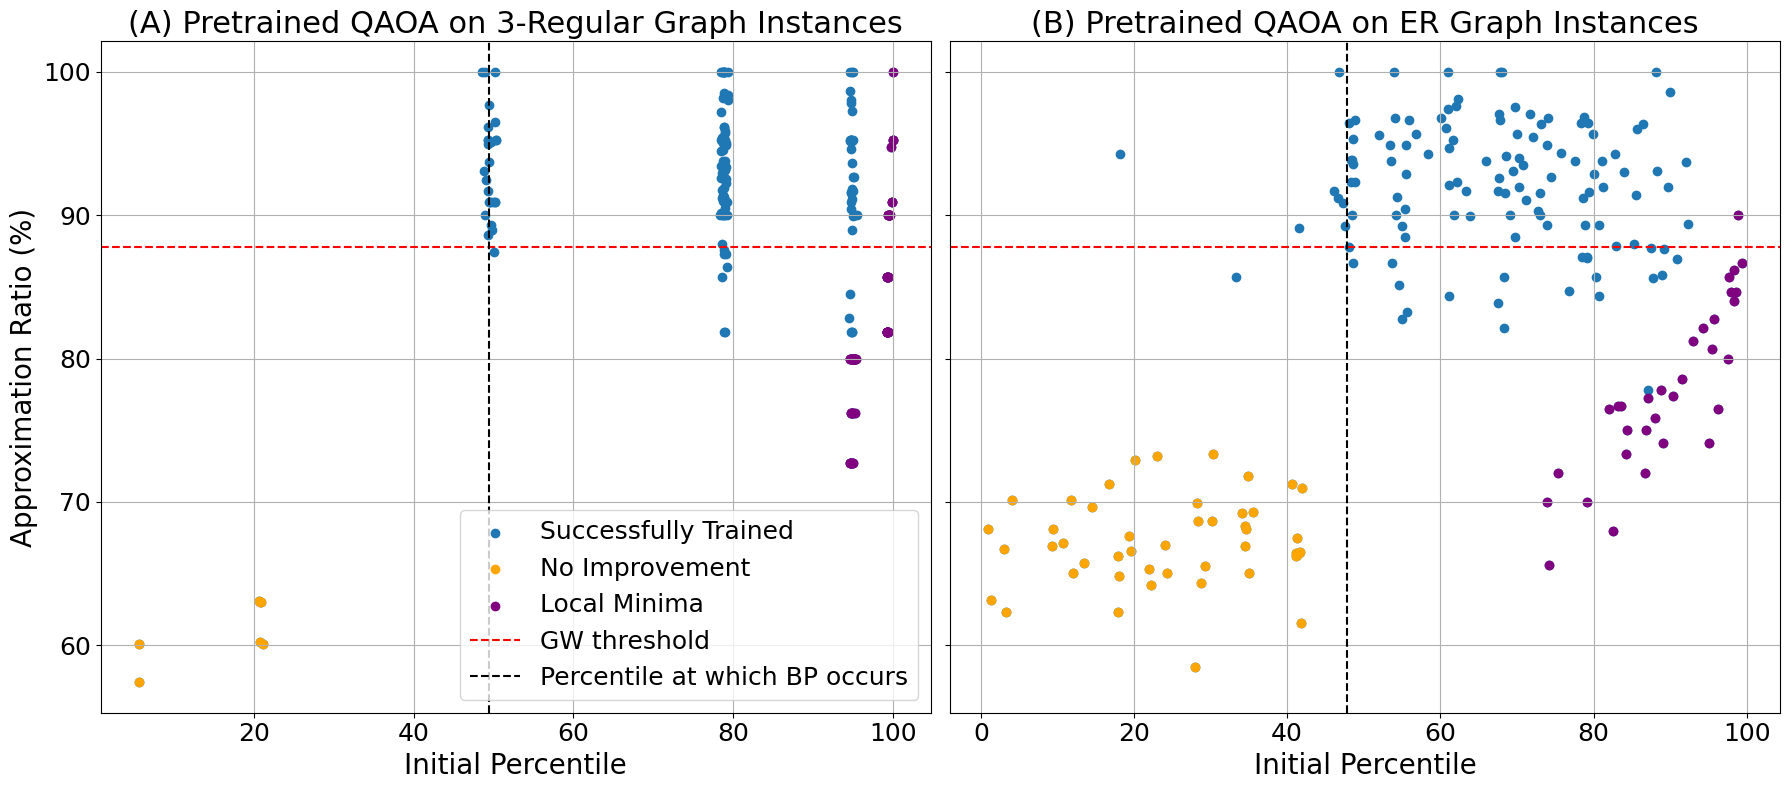

In [294]:
fig, axs = plt.subplots(1, 2, figsize=(18, 8),sharey=True)  # Increased height for better readability

seeds_LM_ER=np.array(Pretrained_3R_results['seeds'])[indices_LM_ER]
seeds_LM_3R=np.array(Pretrained_3R_results['seeds'])[indices_LM_3R]

# Define font sizes
title_fontsize = 22
label_fontsize = 20
tick_fontsize = 18

# First scatter plot on the left subplot
axs[0].scatter(
    np.array(percentiles_3R)[:,0],
    100*np.array(percentiles_3R)[:,1],
    label="Successfully Trained"
)
axs[0].scatter(
    np.array(percentiles_3R)[seeds_BP_3R,0],
    100*np.array(percentiles_3R)[seeds_BP_3R,1],
    color='orange' ,
    label="No Improvement"
)
axs[0].scatter(
    np.array(percentiles_3R)[seeds_LM_3R,0],
    100*np.array(percentiles_3R)[seeds_LM_3R,1],
    color='purple',
    label="Local Minima"
)
axs[0].set_title(
    '(A) Pretrained QAOA on 3-Regular Graph Instances',
    fontsize=title_fontsize
)
axs[0].set_xlabel('Initial Percentile', fontsize=label_fontsize)
axs[0].set_ylabel('Approximation Ratio (%)', fontsize=label_fontsize)
axs[0].tick_params(axis='both', which='major', labelsize=tick_fontsize)
axs[0].grid(True)
axs[0].axhline(y=87.8, color='red', linestyle='--',label="GW threshold") 
axs[0].axvline(x=np.mean(Rall_trials16_3R), color='black', linestyle='--', label="Percentile at which BP occurs") 
axs[0].legend(loc='lower right', fontsize=18)

# Second scatter plot on the right subplot
axs[1].scatter(
    np.array(percentiles_ER)[:,0],
    100*np.array(percentiles_ER)[:,1]
)
axs[1].scatter(
    np.array(percentiles_ER)[seeds_BP_ER,0],
    100*np.array(percentiles_ER)[seeds_BP_ER,1],
    color='orange'
)
axs[1].scatter(
    np.array(percentiles_ER)[seeds_LM_ER,0],
    100*np.array(percentiles_ER)[seeds_LM_ER,1],
    color='purple'
)

axs[1].set_title(
    '(B) Pretrained QAOA on ER Graph Instances',
    fontsize=title_fontsize
)
axs[1].set_xlabel('Initial Percentile', fontsize=label_fontsize)
axs[1].tick_params(axis='both', which='major', labelsize=tick_fontsize)
axs[1].grid(True)
axs[1].axhline(y=87.8, color='red', linestyle='--',label="GW threshold")  
axs[1].axvline(x=np.mean(Rall_trials16_ER), color='black', linestyle='--',label="Mean BP percentile") 


# Adjust layout to prevent overlap
plt.tight_layout()


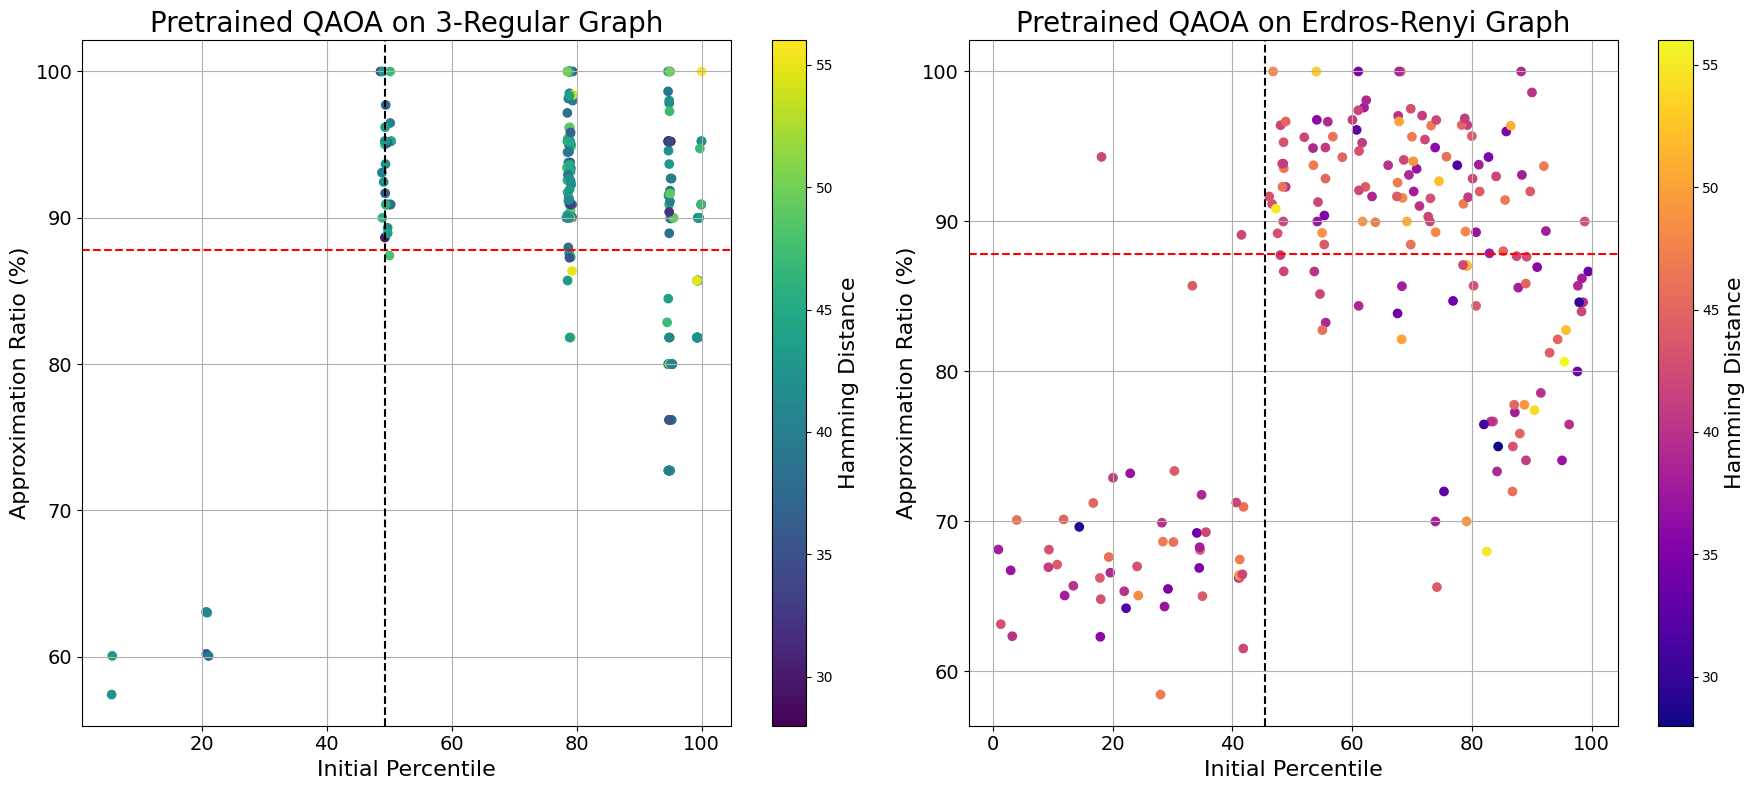

In [275]:
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

# Define font sizes
title_fontsize = 20
label_fontsize = 16
tick_fontsize = 14


# First scatter plot on the left subplot (Pretrained QAOA on 3-Regular Graph)
sc1 = axs[0].scatter(
    np.array(percentiles_3R)[:,0],  # x-axis (Initial Percentile)
    100*np.array(percentiles_3R)[:,1],  # y-axis (Approximation Ratio)
    c=np.array(Pretrained_ER_results['edit_dists'])[:, 0],  # Colour map by Hamming Distance
    cmap='viridis'  # Colour map style
)
axs[0].set_title('Pretrained QAOA on 3-Regular Graph', fontsize=title_fontsize)
axs[0].set_xlabel('Initial Percentile', fontsize=label_fontsize)
axs[0].set_ylabel('Approximation Ratio (%)', fontsize=label_fontsize)
axs[0].tick_params(axis='both', which='major', labelsize=tick_fontsize)
axs[0].grid(True)
axs[0].axhline(y=87.8, color='red', linestyle='--')  # Horizontal line at 87.8
axs[0].axvline(x=49.4, color='black', linestyle='--')  # Vertical line at 49.4

# Add colorbar for the first plot
cbar1 = fig.colorbar(sc1, ax=axs[0])
cbar1.set_label('Hamming Distance', fontsize=label_fontsize)

# Second scatter plot on the right subplot (Pretrained QAOA on Erdros-Renyi Graph)
sc2 = axs[1].scatter(
    np.array(percentiles_ER)[:,0],  # x-axis (Initial Percentile)
    100*np.array(percentiles_ER)[:,1],  # y-axis (Approximation Ratio)
    c=np.array(Pretrained_ER_results['edit_dists'])[:, 0],  # Colour map by Hamming Distance
    cmap='plasma'  # Colour map style
)
axs[1].set_title('Pretrained QAOA on Erdros-Renyi Graph', fontsize=title_fontsize)
axs[1].set_xlabel('Initial Percentile', fontsize=label_fontsize)
axs[1].set_ylabel('Approximation Ratio (%)', fontsize=label_fontsize)
axs[1].tick_params(axis='both', which='major', labelsize=tick_fontsize)
axs[1].grid(True)
axs[1].axhline(y=87.8, color='red', linestyle='--')  # Horizontal line at 87.8
axs[1].axvline(x=45.5, color='black', linestyle='--')  # Vertical line at 45.5

# Add colorbar for the second plot
cbar2 = fig.colorbar(sc2, ax=axs[1])
cbar2.set_label('Hamming Distance', fontsize=label_fontsize)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


## Section 6: Conjecture 2: Demonstrating different parameters may be trained to.
The pretraining was run on Setonix 5 times until convergence. See File.py for example implimentation. The determined parameters were then run on 3 instances. The collected data and initial parameters are stored in the folders Trial_Different_Params and Different_Params respectively.

In [ ]:
import pandas as pd

# Define the directory containing the parameter files
directory = 'different_params'

# Initialize an empty list to store the data
data_list = []

# Iterate over all files in the directory
for filename in os.listdir(directory):
    # Check if the file matches the expected pattern
    if filename.startswith('Graph_Parameters16_256_trial_') and filename.endswith('.npz'):
        # Extract the trial number from the filename
        trial_number_str = filename.split('_')[-1].replace('.npz', '')
        trial_number = int(trial_number_str)
        
        # Load the .npz file
        data = np.load(os.path.join(directory, filename))
        parameters = [data[key] for key in data]
        gamma = np.array(parameters[0])
        beta = np.array(parameters[1])
        
        # Demonstrate the convergence
        # Ensure that the QAOA module and functions are properly imported
        # from your QAOA implementation
        GP = QAOA.random_graph(16, G_type="path", weighted=False, seed=1, p=0.3)
        Q, qc, gamma_params, time_params = QAOA.set_up_sim(16, 256, GP)
        result = QAOA.expectation(Q, qc, GP, gamma_params, time_params, gamma, beta, 256, optimize=False, return_max_prob=True)
        
        # Calculate the approximation ratio and probability on the optimal solution
        approximation_ratio = 100*result[0] / 15  # Replace 15 with the optimal MaxCut value if different
        probability_on_optimal = result[1] * 100  # Convert to percentage
        
        print(f"The approximation ratio is: {approximation_ratio} with {probability_on_optimal}% of the probability on the optimal solution")
        
        # Get the first 2 values of gamma and beta
        gamma_first2 = gamma[:2]
        beta_first2 = beta[:2]
        
        # Prepare a dictionary to hold the data
        data_dict = {'Trial': trial_number}
        # Add gamma and beta values to the dictionary, rounding them
        for i in range(2):
            data_dict[f'Gamma_{i+1}'] = round(gamma_first2[i], 6)
            data_dict[f'Beta_{i+1}'] = round(beta_first2[i], 6)
        
        # Add approximation ratio and probability to the dictionary
        data_dict['Approximation_Ratio'] = round(approximation_ratio, 6)
        data_dict['Probability_on_Optimal'] = round(probability_on_optimal, 6)
        
        # Append the dictionary to the data list
        data_list.append(data_dict)

# Create a DataFrame from the data list
df = pd.DataFrame(data_list)

# Reorder data so the original parameter set is given by 0


df['Trial'] = df['Trial'] + 1

trial_5_row = df[df['Trial'] == 6]


df.loc[df['Trial'] == 6, 'Trial'] = 0


df = df.sort_values('Trial').reset_index(drop=True)

print(df)



The approximation ratio is: 99.99999739546959 with 99.99997819333994% of the probability on the optimal solution
The approximation ratio is: 99.9999987347646 with 99.99998883054566% of the probability on the optimal solution
The approximation ratio is: 99.99999888364114 with 99.99999048893345% of the probability on the optimal solution
The approximation ratio is: 99.99999867598859 with 99.99998915290081% of the probability on the optimal solution
The approximation ratio is: 99.99996550928641 with 99.9997073013573% of the probability on the optimal solution
The approximation ratio is: 99.9999985915311 with 99.99998797703327% of the probability on the optimal solution
   Trial   Gamma_1    Beta_1   Gamma_2    Beta_2  Approximation_Ratio  \
0      0  2.366560  5.551636  6.107969  4.047513            99.999999   
1      1  0.670497  1.476256  4.376024  4.032207            99.999999   
2      2  2.351583  4.329650  1.161440  4.191453            99.999997   
3      3  4.727234  1.138542  5.9

In [ ]:
# Convert to LaTex table for thesis
df.rename(columns={
    'Trial': 'Trial',
    'Gamma_1': r'\ensuremath{\gamma^{P}_{1}}',
    'Gamma_2': r'\ensuremath{\gamma^{P}_{2}}',
    'Beta_1': r'\ensuremath{\beta_{1}}',
    'Beta_2': r'\ensuremath{\beta_{2}}',
    'Approximation_Ratio': 'Approx. Ratio (\%)',
    'Probability_on_Optimal': 'Prob. on Optimal (\%)'
}, inplace=True)



latex_table = df.to_latex(
    index=False,
    float_format="%.6f",
    column_format="rcccccc",
    header=True,
    escape=False  
)


with open('gamma_beta_table.tex', 'w') as f:
    f.write(latex_table)


<>:9: SyntaxWarning: invalid escape sequence '\%'
<>:10: SyntaxWarning: invalid escape sequence '\%'
<>:9: SyntaxWarning: invalid escape sequence '\%'
<>:10: SyntaxWarning: invalid escape sequence '\%'
/var/folders/q3/xxgs0spd7zb3dm4dd5dbt3yh0000gn/T/ipykernel_2758/3905193731.py:9: SyntaxWarning: invalid escape sequence '\%'
  'Approximation_Ratio': 'Approx. Ratio (\%)',
/var/folders/q3/xxgs0spd7zb3dm4dd5dbt3yh0000gn/T/ipykernel_2758/3905193731.py:10: SyntaxWarning: invalid escape sequence '\%'
  'Probability_on_Optimal': 'Prob. on Optimal (\%)'


In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
import numpy as np
import os

# Folder containing the text files
folder = "Trial_Different_Params"
titles = {1: "(A)", 2: "(B)", 3: "(C)"}

# functions to extract data, there are two as the original data was formatted differently to the parameter trial runs
def extract_data_from_file(filepath):
    with open(filepath, 'r') as file:
        lines = file.readlines()

    trial = None
    max_cut = None
    cut_values = []
    
    # Extracting trial number, MaxCut, and cut values from the file
    for line in lines:
        if line.startswith(" TRIAL:"):
            trial = int(line.split(":")[1].strip())
        elif "Maxcut" in line:

            max_cut = float(line.split("Maxcut:")[1].split(",")[0].strip())
        elif line.startswith("-"):
            # Extracting cut values (stored as negative values, hence take negative of them)
            cut_values.append(-float(line.strip()))
    
    return trial, max_cut, cut_values


def extract_data_from_file2(filepath):
    with open(filepath, 'r') as file:
        lines = file.readlines()

    max_cut = None
    cut_values = []
    
    # Extracting MaxCut and cut values from the file
    for line in lines:
        if "Maxcut" in line:

            max_cut = float(line.split("Maxcut:")[1].split(",")[0].strip())
        elif line.startswith("-"):
            # Extracting cut values (stored as negative values, hence take negative of them)
            cut_values.append(-float(line.strip()))
    
    return max_cut, cut_values

# Collecting data from the folder
data = {}
for filename in os.listdir(folder):
    if filename.endswith(".txt"):
        parts = filename.split("_")
        seed = int(parts[4])
        trial, max_cut, cut_values = extract_data_from_file(os.path.join(folder, filename))
        
        if seed not in data:
            data[seed] = {}
        
        # Storing max_cut and cut_values together
        data[seed][trial] = {'max_cut': max_cut, 'cut_values': cut_values}

for seed in [6, 37, 116]: 
    filepath = os.path.join('FINAL_ER30_PRETRAINED', f"P_Seed_{seed}_Qubits_16_Layers_256.txt")

    max_cut, cut_values = extract_data_from_file2(filepath)
        
    # Storing max_cut and cut_values together
    data[seed][6] = {'max_cut': max_cut, 'cut_values': cut_values}

seeds = sorted(data.keys())


/var/folders/q3/xxgs0spd7zb3dm4dd5dbt3yh0000gn/T/ipykernel_2758/1383180445.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


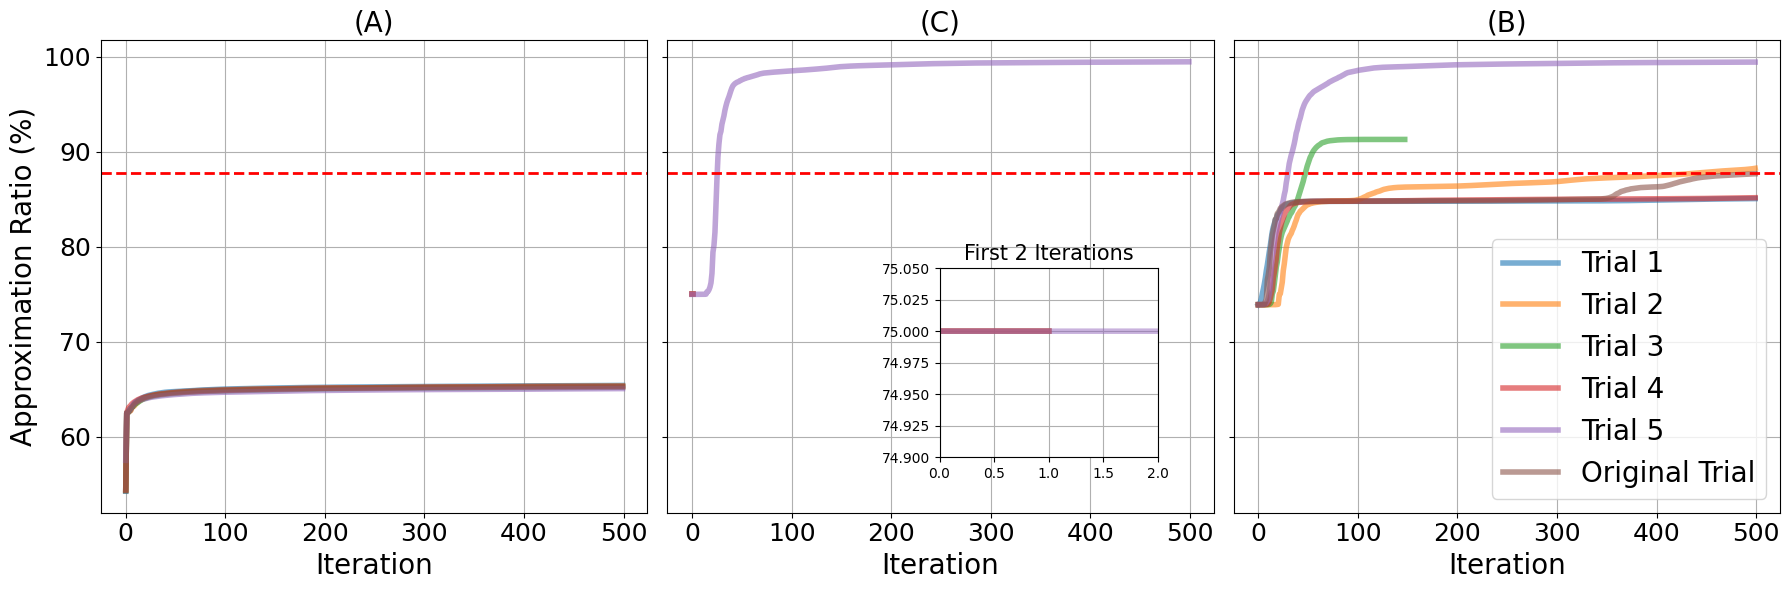

In [ ]:
# Update titles to swap positions of B and C
titles = {1: "(A)", 2: "(C)", 3: "(B)"}

# Plotting data
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
seeds = sorted(data.keys())

for i, seed in enumerate(seeds):
    # Swap the index for B and C
    subplot_index = 2 if i == 1 else 1 if i == 2 else i
    
    for trial in sorted(data[seed].keys()):
        iterations = range(len(data[seed][trial]['cut_values']))
        max_cut = data[seed][trial]['max_cut']
        cut_values = np.array(data[seed][trial]['cut_values'])
        
        # Calculate approximation ratio
        approximation_ratio = cut_values / max_cut
        
        # Plot the approximation ratio
        if trial < 6:
            axes[subplot_index].plot(iterations, 100 * approximation_ratio, label=f"Trial {trial+1}", alpha=0.6, linewidth=4)
        else:
            axes[subplot_index].plot(iterations, 100 * approximation_ratio, label=f"Original Trial", alpha=0.6, linewidth=4)
    
    axes[subplot_index].set_title(titles[subplot_index+1], fontsize=20)
    axes[subplot_index].set_xlabel("Iteration", fontsize=20)
    axes[subplot_index].tick_params(axis='both', which='major', labelsize=18)  # Increase tick label font size
    axes[subplot_index].grid(True)
    if subplot_index == 2:
        axes[subplot_index].legend(fontsize=20, loc='lower right')
    axes[subplot_index].axhline(y=87.8, color='red', linestyle='--', linewidth=2)  # Add horizontal line at 87.8
    
    # For the third subplot (now subplot_index 1, corresponding to seed 6), add an inset zoom on the first few iterations
    if subplot_index == 1:
        # Creating an inset axes in the second subplot (formerly third)
        ax_inset = inset_axes(axes[subplot_index], width="40%", height="40%", loc="lower right", borderpad=4)

        # Zooming in on the first two iterations
        for trial in sorted(data[seed].keys()):
            iterations = range(len(data[seed][trial]['cut_values']))
            cut_values = np.array(data[seed][trial]['cut_values'])
            approximation_ratio = cut_values / max_cut

            # Plot the zoomed-in approximation ratio for the first two iterations
            ax_inset.plot(iterations[:3], 100 * approximation_ratio[:3], label=f"Trial {trial}", linewidth=4, alpha=0.5)
        
        ax_inset.set_xlim(0, 2)  # Limiting x-axis to the first 2 iterations
        ax_inset.set_ylim(74.9, 75.05)  # Adjust y-axis limits to show approximation ratio better
        ax_inset.set_title("First 2 Iterations", fontsize=15)
        ax_inset.grid(True)

axes[0].set_ylabel("Approximation Ratio (%)", fontsize=20)

plt.tight_layout()
plt.show()
